In [61]:
"""/* cosyrush.cc ****************************************************************-*-c++-*-
**
**
**
Example program for the GAMMA Project
**
**
**
** The Program reads a spin system (number of spins, chemical shifts and
**
** J-coupling constants) from a file and simulates a normal COSY experiment **
** using RuSH for quadrature detection in t1
**
**
**
** NOTE: Set to work only on HOMONUCLEAR systems
**
**
**
**************************************************************************************** */
#include <gamma.h>

// Define Constants

const int t1pts = 512;  // Number of t1 points
const int t2pts = 512;  // Number of t2 points

// Begin Program

main (int argc, char* argv[])  // 22 1.5 COSY with RuSH Method
{
    cout << “\Homonuclear COSY Simulation with RuSH Mode\n”;

    //Read in the Spin System

    String filename;                                                       // Name of spin system file
    query_parameter(argc, argv, 1, “\nSpin system filename? “, filename);  // Get filename from command
                                                                           // line or ask for it
    spin_system sys;                                                       // Declare spin system sys
    sys.read(filename);                                                    // Read system from filename 
    
    // Set Offsets and Spectral Widths

    double offset = sys.center();                 // Find approx. spectrum center
    sys.offsetShifts(offset);                     // Offset shifts so centered
    double NyqF = sys.Nyquist(0, 1.4);            // Approximate Nyquist frequency
    double t2dt = 1.0/(2.0*NyqF);                 // t2 time increment
    double t1dt = t2dt;                           // t1 time increment

    //  Set Up Hamiltonian

    char J;
    query_parameter(argc, argv, 2, “\nWeak or strong coupling (w/s)?”, J);
    gen_op H;

    if (J == ‘w’)
        H = Hcs(sys) + HJw(sys);
    else
        H = Hcs(sys) + HJ(sys);

    gen_op Upx = Ixypuls_U(sys,0.0,90.0);          // Propagator for x pulse
    gen_op Upy = Ixypuls_U(sys,90.0,90.0);         // Propagator for y pulse
    gen_op Ud1 = prop(H, t1dt);                    // Propagator t1 delay increment
    gen_op D = Fm(sys);                            // Detector to F-
    gen_op sigma0, sigma1, sigma2, sigma3;         // Set up density matrices
    
    block_1D t2BLK(t2pts);                         // Set 1D block for output Pulse Sequence and I/O Setup
    
    // Declare and open two files

    File cosyRe, cosyIm;

    cosyRe.open(“cosyRuSH.Redat”,io_writeonly, a_create);
    cosyIm.open(“cosyRuSH.Imdat”,io_writeonly, a_create);

    // Apply Pulse Sequence

    gen_op sigma0 = sigma_eq(sys);                // Set density matrix equilibrium
    gen_op sigma1 = evolve(sigma0, Upx);          // Apply first (PI/2)x pulse
    gen_op sigma2 = sigma1;                       // Initial sigma2 (t1 = 0)   

    for (int t1=0; t1<t1pts; t1++)                // Loop over all t1 increments
    {
        sigma3 = evolve(sigma2, Upx);             // Apply second (PI/2)x pulse
        FID(sigma3,D,H,t2dt,t2pts,t2BLK);         // Acquire data for reals
        Felix(cosyRe, t2BLK);                     // Output block for reals: Felix
        
        sigma3 = evolve(sigma2, Upy);             // Apply second (PI/2)y pulse
        FID(sigma3,D,H,t2dt,t2pts,t2BLK);         // Acquire data for imaginaries
        Felix(cosyIm, t2BLK);                     // Output block for imags: Felix
        evolve_ip(sigma2, Ud1);                   // evolution to next t1
    }

    cosyRe.close();                               // Close files
    cosyIm.close();


""";

In [62]:
import pygamma
import pylab
import numpy 
import nmrglue
from pygamma import spin_system, Hcs, HJw, Fm, gen_op, sigma_eq, Iypuls, Ixpuls,evolve, FID, row_vector

from scipy import fftpack

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

### DEFINE SYSTEM & NMR PARAMETERS

In [63]:
dt1 = 0.001 # t1 time increment
dt2 = 0.001 # t2 time increment
t1pts = 1024 # points on t1 axis
t2pts = 1024 # points on t2 axis

In [64]:
sys=spin_system()     # define the system, read in
sys.read("cosy1.sys") # from disk

print sys

Spin Index :      0            1            2      
Isotope    :      1H           1H           1H     
Momentum   :     1/2          1/2          1/2     
Shifts     :     0.00 Hz      0.00 Hz      0.00 Hz 
           :     0.50 ppm     0.25 ppm     0.10 ppm
Js Spin 0  :                 10.00 Hz      0.00 Hz 
Js Spin 1  :                              15.00 Hz 
Omega      :   400.00 MHz   400.00 MHz   400.00 MHz



### SET UP NECESSARY VARIABLES


In [65]:
tmp = row_vector(t2pts)                                    #block_1D tmp(t2pts); // 1D-data block storage
data1 = numpy.zeros((t1pts,t2pts), dtype=numpy.complex128) #block_2D data(t1pts,t2pts); // 2D-data matrix storage
data2 = numpy.zeros((t1pts,t2pts), dtype=numpy.complex128) #block_2D data(t1pts,t2pts); // 2D-data matrix storage

H = Hcs(sys)+ HJw(sys)                                    # // Hamiltonian, weak coupling
detect = gen_op(Fm(sys))                                  # // F- for detection operator


### APPLY PULSE SEQUENCE

In [66]:
sigma0 = sigma_eq(sys)                      # // equilibrium density matrix
sigma1 = Iypuls(sys, sigma0, 90)            #; // apply first 90 y-pulse

In [67]:
for t1 in range(t1pts):
    sigma=evolve(sigma1, H, t1*dt1)         #; // evolution during t1
    sigma=Iypuls(sys, sigma, 90)            #; // apply second 90 y-pulse
    FID(sigma,detect,H,dt2,t2pts,tmp)       #; // acquisition

    data1[t1] =  tmp.toNParray()


In [68]:
sigma0 = sigma_eq(sys)                      # // equilibrium density matrix
sigma1 = Iypuls(sys, sigma0, 90)            #; // apply first 90 y-pulse

In [69]:
for t1 in range(t1pts):
    sigma=evolve(sigma1, H, t1*dt1)         #; // evolution during t1
    sigma=Ixpuls(sys, sigma, 90)            #; // apply second 90 x-pulse
    FID(sigma,detect,H,dt2,t2pts,tmp)       #; // acquisition

    data2[t1] =  tmp.toNParray()


### Apply QSIN processing in both dimensions, 2D-FFT and display in absolute mode

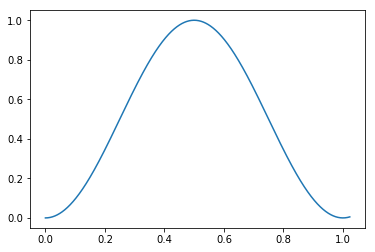

In [70]:
ph1 = pylab.pi/1.
aq = 1./dt2

ttt = numpy.arange(t2pts)/aq

qsin = (pylab.sin((2.0*pylab.pi-ph1)*ttt+ph1))**2
pylab.plot(ttt,qsin);

In [71]:
ddd1 =  qsin*data1
ddd2 =  qsin*data2

In [72]:
fid1 = fftpack.fft(ddd1, axis=1)
fid1 = fftpack.fftshift(fid1, axes=1)

In [73]:
fid2 = fftpack.fft(ddd2, axis=1)
fid2 = fftpack.fftshift(fid2, axes=1)

In [74]:
fid1 = fid1*qsin[:,numpy.newaxis]

In [75]:
fid2 = fid2*qsin[:,numpy.newaxis]

In [76]:
fid = fid1.real+1j*fid2.real

In [77]:
spec = fftpack.fft(fid, axis=0)

In [78]:
spec = fftpack.fftshift(spec, axes=0)

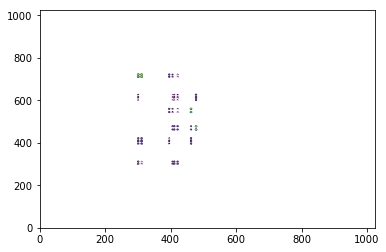

In [79]:
absSpec = abs(spec)
absSpec = numpy.fliplr(absSpec)   # flip spectrum up down and left to right to obtain correct  Bruker configuration
absSpec = numpy.flipud(absSpec)
pylab.contour(absSpec);

In [80]:
spec.real.max()

69208.922085026221

In [81]:
spec.real.min()

-63821.547650633445

### Plot in ppm making use of NMRGLUE python package

In [82]:
info = {}
pinfo = {}

In [83]:
pinfo['procs']={}
pinfo['proc2s']={}

In [84]:
pinfo['procs']['OFFSET']=1.25

In [85]:
pinfo['procs' ]['SW_p']=1.0/dt1

In [86]:
pinfo['procs' ]['SF']=sys.spectrometer_frequency()

In [87]:
pinfo['proc2s' ]['OFFSET'] =1.25
pinfo['proc2s' ]['SW_p']=1.0/dt2
pinfo['proc2s' ]['SF']=sys.spectrometer_frequency()
        
        
        

In [88]:
class TwoD_NMR_MAT_plot:
    
    def __init__(self, exp, pinfo, info, dimensions_ppm=[]):
        
#        print exp.shape
        
        self.exp = exp
        self.pinfo = pinfo
        self.info  = info
        
        self.rr,self.cc = exp.shape
        self.X = numpy.zeros(exp.shape)
        self.Y = numpy.zeros(exp.shape)
        
        r1=0
        r2=self.rr

        c1=0
        c2=self.cc
        
#        print r2,c2
        
        self.create_axes(  pinfo, info, self.rr, self.cc, dimensions_ppm )
          
        self.create_plot_layout(self.dimensions_index)
        
        self.plot_plots()
        

        
    def create_axes( self, pinfo, info, rr,cc, dimensions_ppm):
                
        self.f1_offset_p = pinfo['procs' ]['OFFSET']
        self.f1_sw_hz     = pinfo['procs' ]['SW_p']
        self.f1_omega    = pinfo['procs' ]['SF']
        self.f1_sw_ppm   = self.f1_sw_hz/self.f1_omega
        
        self.f2_offset_p = pinfo['proc2s' ]['OFFSET']
        self.f2_sw_hz     = pinfo['proc2s' ]['SW_p']
        self.f2_omega    = pinfo['proc2s' ]['SF']
        self.f2_sw_ppm   = self.f2_sw_hz/self.f2_omega
#        print self.f1_sw_ppm
        
        self.f1 = numpy.linspace(self.f1_offset_p, self.f1_offset_p-self.f1_sw_ppm,  self.rr)
        self.f2 = numpy.linspace(self.f2_offset_p, self.f2_offset_p-self.f2_sw_ppm,  self.cc)
        
        self.dw_f1_ppm = self.f1[1]-self.f1[0]
        self.dw_f2_ppm = self.f2[1]-self.f2[0]
        
        for r in range(self.rr):
    
            for c in range( self.cc):
        
                self.Y[r,c] = self.f1[r]
                self.X[r,c] = self.f2[c] 
                
#        print dimensions_ppm       
        if dimensions_ppm == []:
            self.dimensions_index = numpy.array([0,self.rr-1,0,self.cc-1])
        else:
            r1 = int( (dimensions_ppm[1]-self.f1_offset_p)/self.dw_f1_ppm)
            r2 = int( (dimensions_ppm[0]-self.f1_offset_p)/self.dw_f1_ppm)
            c1 = int( (dimensions_ppm[2]-self.f2_offset_p)/self.dw_f2_ppm)
            c2 = int( (dimensions_ppm[3]-self.f2_offset_p)/self.dw_f2_ppm)
            
            self.dimensions_index = numpy.array([r1,r2,c1,c2 ])
            
#        print "self.dimensions_index", self.dimensions_index
            
        self.Z1 = self.exp[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.X1 =   self.X[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.Y1 =   self.Y[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        
        
    def create_plot_layout( self, dimensions_index):
        
#        print "dimensions_index",dimensions_index
        
        nullfmt   = NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        bottom_h = left_h = left+width+0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(2, figsize=(6,6))

        self.axScatter = plt.axes(rect_scatter)
        self.axHistx = plt.axes(rect_histx)
        self.axHisty = plt.axes(rect_histy)

# no labels
        self.axHistx.xaxis.set_major_formatter(nullfmt)
        self.axHisty.yaxis.set_major_formatter(nullfmt)
        
        self.axScatter.tick_params(axis='x', labelsize=16)
        self.axScatter.tick_params(axis='y', labelsize=16)
        self.axScatter.set_xlabel('${^1}$H [ppm]',fontsize=16)
        #ax.set_xlim(-60, 60)
        self.axScatter.set_ylabel('${^1}$H [ppm]', fontsize=16)
        
        self.axHistx.axis('off')
        self.axHisty.axis('off')

        f1_start = self.f1[dimensions_index[0]]
        f1_end   = self.f1[dimensions_index[1]]

        f2_start = self.f2[dimensions_index[2]]
        f2_end   = self.f2[dimensions_index[3]]

        self.axScatter.set_ylim( (f1_start, f1_end) )
        self.axScatter.set_xlim( (f2_start, f2_end) )
        
        

    def plot_plots(self):
        
        # the scatter plot:
        cl = numpy.linspace(self.Z1.max()*0.01, self.Z1.max()*1.1,10)
#        print "Z1.shape",self.Z1.shape
        

        sum_f1 = self.Z1.sum(axis=0)
#        print "len(sum_f1)",len(sum_f1)
        sum_f2 = self.Z1.sum(axis=1)
#        print "len(sum_f2)",len(sum_f2)

        cset = self.axScatter.contour(self.X1, self.Y1, self.Z1,  cl,  colors='red')
        #
        self.axHistx.plot(sum_f1, 'r-')
        self.axHisty.plot(sum_f2,range(len(sum_f2)),'r')


        self.axHistx.set_xlim( (0,len(sum_f1)-1) )
        self.axHisty.set_ylim( (0,len(sum_f2)-1) )        
        


In [89]:
#ppplot = TwoD_NMR_MAT_plot2(absSpec, pinfo, info, )

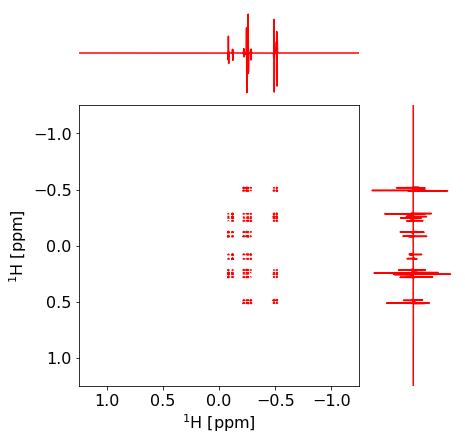

In [90]:
#ppplot = TwoD_NMR_MAT_plot(spec.real, pinfo, info, [0.05,0.55, 0.55,0.05] )
ppplot = TwoD_NMR_MAT_plot(spec.real, pinfo, info)